In [191]:
import pandas as pd
import numpy as np
import data_handler
from tqdm import tqdm
import matplotlib.pyplot as plt

from torchvision import datasets
import os
from itertools import chain, product

from scipy.stats import ttest_1samp, ttest_rel, t
from scipy import stats

In [192]:
DATA_PATH = os.path.join(os.path.curdir, "data", "survey_results", "data_tu-helpfulness-of-xai_2022-07-13_13-03.xlsx")
DATA_PREPARED_PATH = f"{os.path.splitext(DATA_PATH)[0]}_PREPARED{os.path.splitext(DATA_PATH)[1]}"
df = pd.read_excel(DATA_PATH)
df_merged = pd.read_excel(DATA_PREPARED_PATH)

In [193]:
META_DATA_PATH = os.path.join(os.path.curdir, "data", "survey_results", "question_meta_data.xlsx")
df_quest_meta = pd.read_excel(META_DATA_PATH)

# Evaluation Metrics Calculation & Testing

### Metric functions

In [194]:
def accuracy_per_groupby(df_merged, group_by=["method"], drop_na=False):
    # accuracy = (TP + TN) / (TP + TN + FP + FN)
    schema_cols = [df_merged[column].drop_duplicates() for column in group_by + ["is_pred_correct", "response"]]
    schema_col_names = [ser.name for ser in schema_cols]
    df_schema = pd.DataFrame(list(product(*schema_cols))).groupby(list(np.arange(len(schema_cols)))).count()
    df_schema = df_schema.reset_index()
    df_schema.columns=schema_col_names
    
    ser_denominators = df_merged.groupby(by=group_by, dropna=drop_na)["response"].count().sort_index()
    df_numerators = df_merged.groupby(by=group_by + ["is_pred_correct", "response"], dropna=drop_na)["response"].count().to_frame("count").reset_index()
    df_numerators = df_schema.merge(right=df_numerators, on=schema_col_names, how="left").fillna(0)
    ser_numerators = df_numerators[df_numerators["is_pred_correct"] == df_numerators["response"]].groupby(group_by, dropna=drop_na)["count"].sum().sort_index()
    df_accuracies = (ser_numerators / ser_denominators).to_frame("accuracy")
    return df_accuracies

In [195]:
def sensitivity_per_groupby(df_merged, group_by=["method"], drop_na=True):
    # sensitivity = TP / (TP + FN)
    schema_cols = [df_merged[column].drop_duplicates() for column in group_by + ["is_pred_correct", "response"]]
    schema_col_names = [ser.name for ser in schema_cols]
    df_schema = pd.DataFrame(list(product(*schema_cols))).groupby(list(np.arange(len(schema_cols)))).count()
    df_schema = df_schema.reset_index()
    df_schema.columns=schema_col_names
    
    df_merged_filt = df_merged[(df_merged["is_pred_correct"] == True)]
    ser_denominators = df_merged_filt.groupby(by=group_by, dropna=drop_na)["response"].count().sort_index()
    df_numerators = df_merged_filt.groupby(by=group_by + ["is_pred_correct", "response"], dropna=drop_na)["response"].count().to_frame("count").reset_index()
    df_numerators = df_schema.merge(right=df_numerators, on=schema_col_names, how="left").fillna(0)
    ser_numerators = df_numerators[df_numerators["is_pred_correct"] == df_numerators["response"]].groupby(group_by, dropna=drop_na)["count"].sum().sort_index()
    df_sensitivity = (ser_numerators / ser_denominators).to_frame("sensitivity")
    return df_sensitivity

In [196]:
def specificity_per_groupby(df_merged, group_by=["method"], drop_na=True):
    # specificity = TN / (TN + FP)
    schema_cols = [df_merged[column].drop_duplicates() for column in group_by + ["is_pred_correct", "response"]]
    schema_col_names = [ser.name for ser in schema_cols]
    df_schema = pd.DataFrame(list(product(*schema_cols))).groupby(list(np.arange(len(schema_cols)))).count()
    df_schema = df_schema.reset_index()
    df_schema.columns=schema_col_names
    
    df_merged_filt = df_merged[(df_merged["is_pred_correct"] == False)]
    ser_denominators = df_merged_filt.groupby(by=group_by, dropna=drop_na)["response"].count().sort_index()
    df_numerators = df_merged_filt.groupby(by=group_by + ["is_pred_correct", "response"], dropna=drop_na)["response"].count().to_frame("count").reset_index()
    df_numerators = df_schema.merge(right=df_numerators, on=schema_col_names, how="left").fillna(0)
    ser_numerators = df_numerators[df_numerators["is_pred_correct"] == df_numerators["response"]].groupby(group_by, dropna=drop_na)["count"].sum().sort_index()
    df_specificity = (ser_numerators / ser_denominators).to_frame("specificity")
    return df_specificity

In [197]:
def get_metric_convergence(df_metric):
    metric_name = df_metric.columns[0]
    return df_metric.groupby(level=0).expanding().mean().reset_index(level=[1, 2]).\
            pivot(index="case", columns="method", values=metric_name)

### Plotting functions

In [198]:
def plot_metric_boxplot(df_metrics, by, column, xlabel="XAI-Method", ylabel="Accuracy", title=""):
    ax = df_metrics.boxplot(by=by, column=column, figsize=(14, 5), showmeans=True, meanline=True)
    fig = plt.gcf()
    fig.suptitle(None)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    #xai = df_metrics[]
    #ax.plot(["ConfidenceScores", "gradCAM"], [0.5, 0.5], c="red", linestyle="dashed")
    plt.show()
    plt.close()

In [199]:
def plot_sensitivity_specificity(df_sens_mean, df_spec_mean, title_addition=""):
    df_sens_mean = df_sens_mean.sort_index()
    df_spec_mean = df_spec_mean.sort_index()
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.scatter(x=df_sens_mean.index, y=df_sens_mean, c="darkorange", label="Sensitivity: Guessed Correct when Model Correct")
    ax.scatter(x=df_spec_mean.index, y=df_spec_mean, c="olivedrab", label="Specificity: Guessed Wrong when Model Wrong", marker="^")
    ax.plot(df_sens_mean["mean"].index, [0.5] * len(df_sens_mean), color="indianred", linestyle='dashed', label="baseline")
    ax.set_title(f"{title_addition} Performance Ratios for chosen XAI-Methods ({len(df)-1} participants considered)", size=15)
    ax.set_xlabel("XAI-Method", size=13)
    ax.set_ylabel("Ratio", size=13)
    for i, txt in enumerate(df_sens_mean["mean"].round(2)):
        ax.annotate(txt, (list(df_sens_mean.index)[i], list(df_sens_mean["mean"])[i]))
    for i, txt in enumerate(df_spec_mean["mean"].round(2)):
        ax.annotate(txt, (list(df_spec_mean.index)[i], list(df_spec_mean["mean"])[i]))
    ax.legend(loc="best", edgecolor="black")
    ax.tick_params(labelright=True)
    ax.yaxis.set_ticks_position('both')
    plt.savefig("ratios.svg") # sens_vs_spec.svg

In [200]:
def plot_metric_convergence(df_metrics_conv, metric_name="Accuracy"):
    methods_sorted = df_metrics_conv.iloc[-1].sort_values(ascending=False).index.values
    df_metrics_conv = df_metrics_conv[methods_sorted]
    
    methods_names = methods_sorted.copy()
    methods_names.sort()
    colors =["darkorange", "olivedrab","lightseagreen","darkslategrey","royalblue","mediumvioletred"]
    line = ["dotted","dashed","dashdot","dotted","dashed","dashdot"]
    colors_dict = dict(zip(methods_names, colors))
    line_dict = dict(zip(methods_sorted, line))
    
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.set_xlabel("Number Participants", size=13)
    ax.set_ylabel("Accuracy", size=13)
    #ax.set_title(f"Convergence of {metric_name} as Number of Participants increase", size=15)
    df_metrics_conv.apply(lambda method_conv: ax.plot(list(range(len(method_conv))), method_conv, label=method_conv.name, color=colors_dict[method_conv.name],ls=line_dict[method_conv.name]))
    ax.legend(loc="upper right", edgecolor="black")
    ax.tick_params(labelright=True)
    ax.yaxis.set_ticks_position('both')
    plt.savefig("convergence.pdf")

In [201]:
def plot_2_indexes_1_plot(df_double_index, xlabel, ylabel, title, drop_na=True, drop_duplicates=True, mean_idx_order=None):
    fig, ax = plt.subplots(2, 1, figsize=(20, 10))
    plt.setp(ax, ylim=(0, 1.1))
    if drop_duplicates:
        ser_level_1_count = df_merged.drop_duplicates("case").groupby(df_double_index.index.levels[0].name, dropna=drop_na)[df_merged.columns[0]].count()
    else:
        ser_level_1_count = df_merged.groupby(df_double_index.index.levels[0].name, dropna=drop_na)[df_merged.columns[0]].count()
                                                                                                                            
    ser_acc_mean = df_double_index.mean(level=0)[df_double_index.columns[0]]
    # reorder bars in barplot as specified
    if mean_idx_order:
        ser_acc_mean = ser_acc_mean.reindex(mean_idx_order)
                                                                                                                         
    pps = ax[0].bar(ser_acc_mean.index, ser_acc_mean)
    for p in pps:
        height = p.get_height()
        ax[0].text(x=p.get_x() + p.get_width() / 2, y=height+.05,
          s=round(height, 2),
          ha='center', size=12)
    ax[0].set_xlabel(ser_acc_mean.index.name, size=15)
    ax[0].set_ylabel("Accuracy", size=15)
    ax[0].set_title(f"Mean Accuracy over all XAI-Methods per {ser_acc_mean.index.name}", size=20)
    
    for idx_level_1 in df_double_index.index.levels[0]:
        ax[1].plot(df_double_index.loc[idx_level_1].index, list(df_double_index.loc[idx_level_1][df_double_index.columns[0]]), label=f"{idx_level_1} ({ser_level_1_count[idx_level_1]})")
        ax[1].scatter(df_double_index.loc[idx_level_1].index, list(df_double_index.loc[idx_level_1][df_double_index.columns[0]]))
    ax[1].legend()
    ax[1].set_xlabel(xlabel, size=15)
    ax[1].set_ylabel(ylabel, size=15)
    ax[1].set_title(title, size=20)
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.3, wspace=0.4)
    plt.show()
    plt.close()

In [202]:
def bar_plot(df_double_index,filename ,drop_na=True, drop_duplicates=True, mean_idx_order=None):
    fig, ax = plt.subplots(figsize=(14, 5))
    if drop_duplicates:
        ser_level_1_count = df_merged.drop_duplicates("case").groupby(df_double_index.index.levels[0].name, dropna=drop_na)[df_merged.columns[0]].count()
    else:
        ser_level_1_count = df_merged.groupby(df_double_index.index.levels[0].name, dropna=drop_na)[df_merged.columns[0]].count()

    ser_acc_mean = df_double_index.mean(level=0)[df_double_index.columns[0]]
    # reorder bars in barplot as specified
    if mean_idx_order:
        ser_acc_mean = ser_acc_mean.reindex(mean_idx_order)

    pps = ax.bar(ser_acc_mean.index, ser_acc_mean,color="olivedrab")
    for p in pps:
        height = p.get_height()
        ax.text(x=p.get_x() + p.get_width() / 2, y=height+.05,
          s=round(height, 2),
          ha='center', size=12)
    ax.set_xlabel(ser_acc_mean.index.name, size=15)
    ax.set_ylabel("Accuracy", size=15)
    #ax.set_title(f"Mean Accuracy over all XAI-Methods per {ser_acc_mean.index.name}", size=20)
    ax.tick_params(labelright=True)
    ax.set_ylim([0, 1])
    plt.savefig(filename+".svg")
    plt.show()
    plt.close()

In [203]:
def line_plot(df_double_index, xlabel, ylabel,filename, drop_na=True):
    fig, ax = plt.subplots(figsize=(14, 5))

    colors =["darkorange","olivedrab"]
    line = ["dashed","dashdot"]
    idx_level_1 = df_double_index.index.levels[0]

    for i in range(idx_level_1.shape[0]):
        ax.plot(df_double_index.loc[idx_level_1[i]].index, list(df_double_index.loc[idx_level_1[i]][df_double_index.columns[0]]),
                label=f"{idx_level_1[i]}",color=colors[i],ls=line[i]) #({ser_level_1_count[idx_level_1]})
        ax.scatter(df_double_index.loc[idx_level_1[i]].index, list(df_double_index.loc[idx_level_1[i]][df_double_index.columns[0]]),
                   color=colors[i])
    ax.legend(loc="upper right")
    ax.set_xlabel(xlabel, size=13)
    ax.set_ylabel(ylabel, size=13)
    ax.set_ylim([0, 1])
    ax.tick_params(labelright=True)
    plt.savefig(filename+".svg")
    plt.show()
    plt.close()

### Testing & effect size functions

In [204]:
# isn't used currently
def print_test_result(pval, alpha, mean_h_0):
    print(f"p-value: {pval}")
    if pval < alpha:
        print(f"Reject H0: accuracy_mean <= {mean_h_0} \n")
    else:
        print("Can't reject H0 \n")

In [205]:
def perform_t_test(accuracies, mean_h_0, alpha, alternative):
    tset, pval = ttest_1samp(a=accuracies, popmean=mean_h_0, alternative=alternative)
    print(accuracies.name)
    print(f"p-value: {pval.round(3)}")
    if pval < alpha:
        print(f"Reject H0: accuracy_mean <= {mean_h_0} \n")
    else:
        print("Can't reject H0 \n")
    return tset

In [206]:
def perform_t_test_with_flexible_alternative(metrics, mean_h_0, alpha):
    h_a = None
    sample_mean = metrics.mean()
    if sample_mean < mean_h_0:
        h_a = "less"
    elif sample_mean > mean_h_0:
        h_a = "greater"
    else:
        h_a = "two-sided"
    tset, pval = ttest_1samp(a=metrics, popmean=mean_h_0, alternative=h_a)
    
    h_a_to_h_0_mapping = {"less": ">=", "greater": "<=", "two-sided": "equal"}
    print(f"{metrics.name}:  sample_mean={sample_mean}")
    print(f"H0: sample_mean {h_a_to_h_0_mapping[h_a]} {mean_h_0}")
    print(f"p-value: {pval.round(3)}")
    if pval < alpha:
        print(f"Reject H0! (alpha={alpha})\n")
    else:
        print(f"CAN'T reject H0: (alpha={alpha})\n")
    return tset

In [207]:
def get_pairwise_paired_t_test_alternatives_and_p_values(df_metrics, df_metrics_mean):
    paired_test_alternatives = []
    paired_test_pvalues = []
    df_metrics_mean = df_metrics_mean.sort_values(by="mean", ascending=False)
    xai_accuracy_sorted = df_metrics_mean.index.values
    for method_i in xai_accuracy_sorted:
        method_i_alternatives = []
        method_i_pvalues = []
        for method_j in xai_accuracy_sorted:
            # h_a = "less" if df_metrics_mean.loc[method_i]["mean"] < df_metrics_mean.loc[method_j]["mean"] else "greater" if df_metrics_mean.loc[method_i]["mean"] > df_metrics_mean.loc[method_j]["mean"] else None
            h_a = None
            if df_metrics_mean.loc[method_i]["mean"] < df_metrics_mean.loc[method_j]["mean"]:
                h_a = "less"
            elif df_metrics_mean.loc[method_i]["mean"] > df_metrics_mean.loc[method_j]["mean"]:
                h_a = "greater"
            elif (df_metrics_mean.loc[method_i]["mean"] == df_metrics_mean.loc[method_j]["mean"]) & (method_i != method_j):
                h_a = "two-sided"
            method_i_alternatives.append(h_a)
            if h_a is None:
                method_i_pvalues.append(np.nan)
            else:
                a = df_metrics[method_i].values
                b = df_metrics[method_j].values
                tset, pval = ttest_rel(a, b, alternative=h_a)
                method_i_pvalues.append(pval.round(3))
        paired_test_alternatives.append(method_i_alternatives)
        paired_test_pvalues.append(method_i_pvalues)
        
    df_paired_alternatives = pd.DataFrame(paired_test_alternatives, index=xai_accuracy_sorted, columns=xai_accuracy_sorted)
    df_paired_alternatives.index.name = "method_i"
    df_paired_alternatives.columns.name = "method_j"
    
    df_paired_pvalues = pd.DataFrame(paired_test_pvalues, index=xai_accuracy_sorted ,columns=xai_accuracy_sorted)
    df_paired_pvalues.index.name = "method_i"
    df_paired_pvalues.columns.name = "method_j"
    
    return df_paired_alternatives, df_paired_pvalues

In [301]:
# Cohen’s d for one-sample t-test
def cohens_d(t_statistic, N):
    return t_statistic / np.sqrt(N)

### Constants

In [302]:
# significance level
ALPHA = 0.05

## 1. Accuracies

In [211]:
df_acc = accuracy_per_groupby(df_merged, group_by=["method", "case"])
df_acc_pivot = df_acc.reset_index().pivot(index="case", columns="method", values="accuracy")
df_acc_frequencies = df_acc_pivot.apply(lambda x: x.value_counts())
df_acc_conv = get_metric_convergence(df_acc)

### Accuracy means

In [212]:
df_acc_mean = df_acc_pivot.mean().to_frame("mean").sort_values(by="mean", ascending=False)
df_acc_mean.round(2)

,mean
method,
ConfidenceScores,0.70
gradCAM,0.60
LRP,0.58
SHAP,0.56
LIME,0.54
IntegratedGradients,0.53


In [213]:
# overall
df_acc_mean.mean().to_frame("accuracy").mean()

accuracy    0.586331
dtype: float64

### Accuracy boxplots

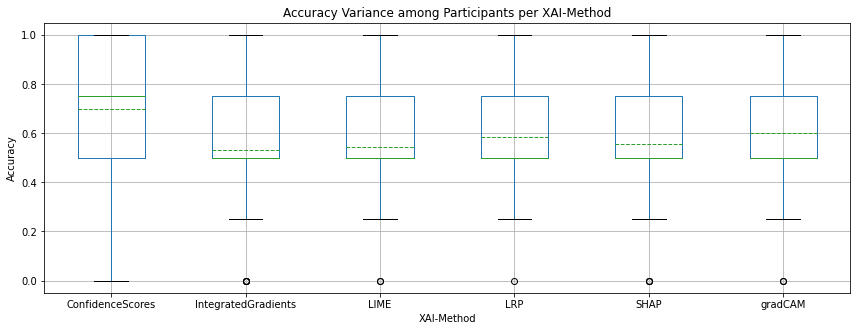

In [214]:
plot_metric_boxplot(df_acc.reset_index(), ["method"], "accuracy", title="Accuracy Variance among Participants per XAI-Method")

### Accuracy convergence

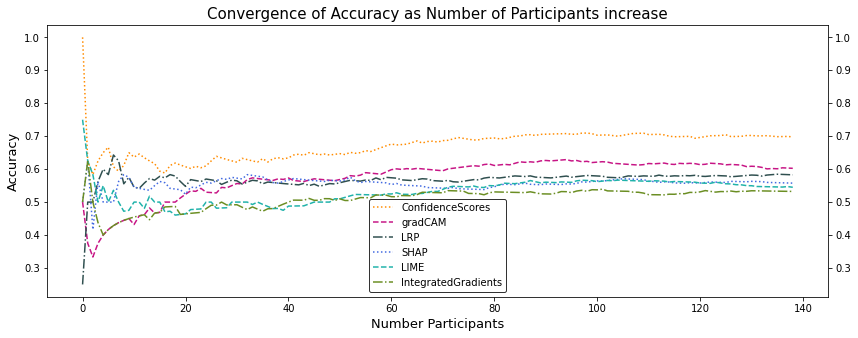

In [215]:
plot_metric_convergence(df_acc_conv)

### Accuracy values  frequencies (all possible discrete according to question resolution)

Text(0, 0.5, 'Number Participants who reached accuracy score')

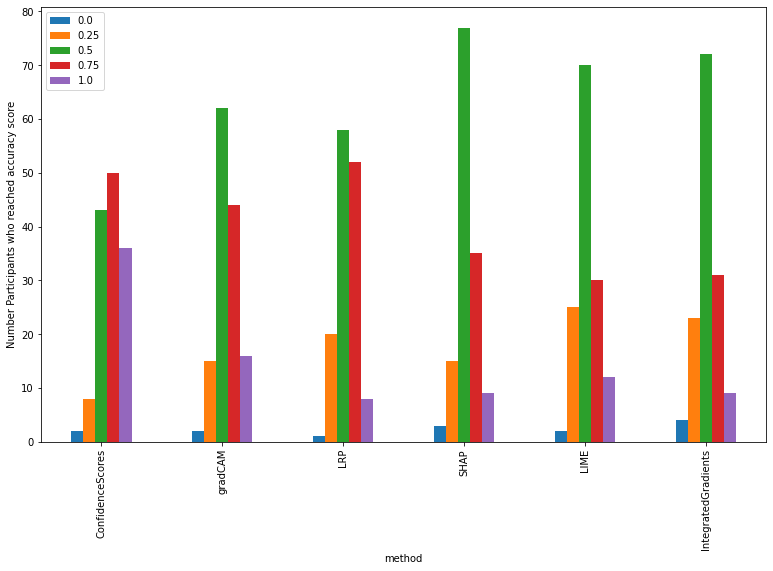

In [216]:
ax = df_acc_frequencies[df_acc_mean.index].transpose().plot.bar(figsize=(13, 8))
ax.set_ylabel("Number Participants who reached accuracy score")

### Significance & Effect Size: Accuracy comparisons to random baseline

#### 1-sample t-test

In [288]:
# test with flexibile alternative
ser_acc_1_sample_t_values = df_acc_pivot.apply(lambda accuracies_method: perform_t_test_with_flexible_alternative(accuracies_method, mean_h_0, ALPHA))

ConfidenceScores:  sample_mean=0.697841726618705
H0: sample_mean <= 0.5
p-value: 0.0
Reject H0! (alpha=0.05)

IntegratedGradients:  sample_mean=0.5323741007194245
H0: sample_mean <= 0.5
p-value: 0.04
Reject H0! (alpha=0.05)

LIME:  sample_mean=0.5449640287769785
H0: sample_mean <= 0.5
p-value: 0.009
Reject H0! (alpha=0.05)

LRP:  sample_mean=0.5827338129496403
H0: sample_mean <= 0.5
p-value: 0.0
Reject H0! (alpha=0.05)

SHAP:  sample_mean=0.5575539568345323
H0: sample_mean <= 0.5
p-value: 0.001
Reject H0! (alpha=0.05)

gradCAM:  sample_mean=0.6025179856115108
H0: sample_mean <= 0.5
p-value: 0.0
Reject H0! (alpha=0.05)



In [312]:
# overall test
df_acc_overall = df_acc_pivot.mean(axis=1)
t_acc_overall = perform_t_test(df_acc_overall, mean_h_0, ALPHA, "greater")
effect_overall = cohens_d(t_acc_overall, len(df_acc_overall))
effect_overall

None
p-value: 0.0
Reject H0: accuracy_mean <= 0.5 



0.8441962418568855

#### Effect size (Cohens d) 

In [290]:

N_acc = df_acc_pivot.shape[0]
df_acc_1_sample_effect = ser_acc_1_sample_t_values.map(lambda t_val: cohens_d(t_val, N_acc)).to_frame("cohens_d").sort_values(by="cohens_d", ascending=False)

In [291]:
df_acc_1_sample_effect.round(2)

,cohens_d
method,
ConfidenceScores,0.84
gradCAM,0.46
LRP,0.40
SHAP,0.28
LIME,0.20
IntegratedGradients,0.15


### Significance & Effect Size: Accuracies pairwise between each other

#### Paired t-test

In [225]:
df_acc_paired_test_alternatives, df_acc_apaired_test_pvalues = get_pairwise_paired_t_test_alternatives_and_p_values(df_acc_pivot, df_acc_mean)

In [226]:
df_acc_paired_test_alternatives

method_j,ConfidenceScores,gradCAM,LRP,SHAP,LIME,IntegratedGradients
method_i,,,,,,
ConfidenceScores,None,greater,greater,greater,greater,greater
gradCAM,less,None,greater,greater,greater,greater
LRP,less,less,None,greater,greater,greater
SHAP,less,less,less,None,greater,greater
LIME,less,less,less,less,None,greater
IntegratedGradients,less,less,less,less,less,None


In [227]:
df_acc_apaired_test_pvalues

method_j,ConfidenceScores,gradCAM,LRP,SHAP,LIME,IntegratedGradients
method_i,,,,,,
ConfidenceScores,NaN,0.000,0.000,0.000,0.000,0.000
gradCAM,0.0,NaN,0.204,0.031,0.009,0.005
LRP,0.0,0.204,NaN,0.149,0.051,0.020
SHAP,0.0,0.031,0.149,NaN,0.301,0.139
LIME,0.0,0.009,0.051,0.301,NaN,0.312
IntegratedGradients,0.0,0.005,0.020,0.139,0.312,NaN


In [228]:
df_acc_apaired_test_pvalues < ALPHA

method_j,ConfidenceScores,gradCAM,LRP,SHAP,LIME,IntegratedGradients
method_i,,,,,,
ConfidenceScores,False,True,True,True,True,True
gradCAM,True,False,False,True,True,True
LRP,True,False,False,False,False,True
SHAP,True,True,False,False,False,False
LIME,True,True,False,False,False,False
IntegratedGradients,True,True,True,False,False,False


#### Effect size in compare (Cohens d)

## 2. Sensitivity

In [230]:
df_sens = sensitivity_per_groupby(df_merged, group_by=["method", "case"])
df_sens_pivot = df_sens.reset_index().pivot(index="case", columns="method", values="sensitivity")
df_sens_frequencies = df_sens_pivot.apply(lambda x: x.value_counts())
df_sens_conv = get_metric_convergence(df_sens)

### Sensitivity means

In [231]:
df_sens_mean = df_sens_pivot.mean().to_frame("mean").sort_values(by="mean", ascending=False)
df_sens_mean.round(2)

,mean
method,
gradCAM,0.78
ConfidenceScores,0.75
LRP,0.75
LIME,0.59
IntegratedGradients,0.56
SHAP,0.33


In [232]:
# overall
df_sens_mean.mean()

mean    0.628297
dtype: float64

### Sensitivity boxplots

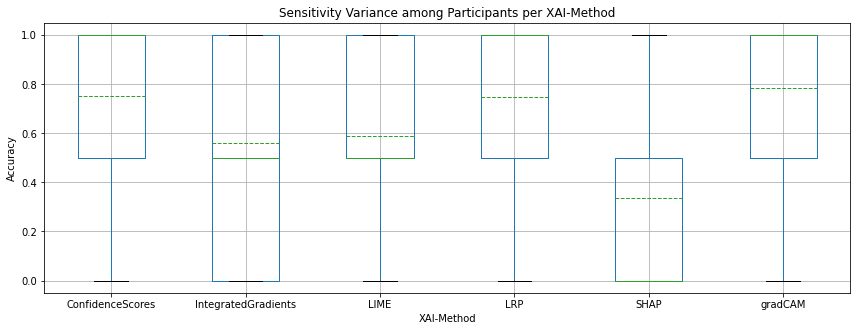

In [233]:
plot_metric_boxplot(df_sens.reset_index(), ["method"], "sensitivity", title="Sensitivity Variance among Participants per XAI-Method")

### Sensitvity convergence

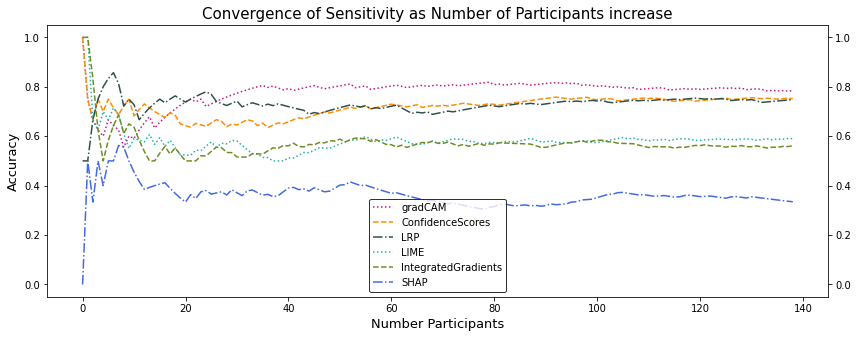

In [234]:
plot_metric_convergence(df_sens_conv, metric_name="Sensitivity")

### Sensitivity values  frequencies (all possible discrete according to question resolution)

Text(0, 0.5, 'Number Participants who reached accuracy score')

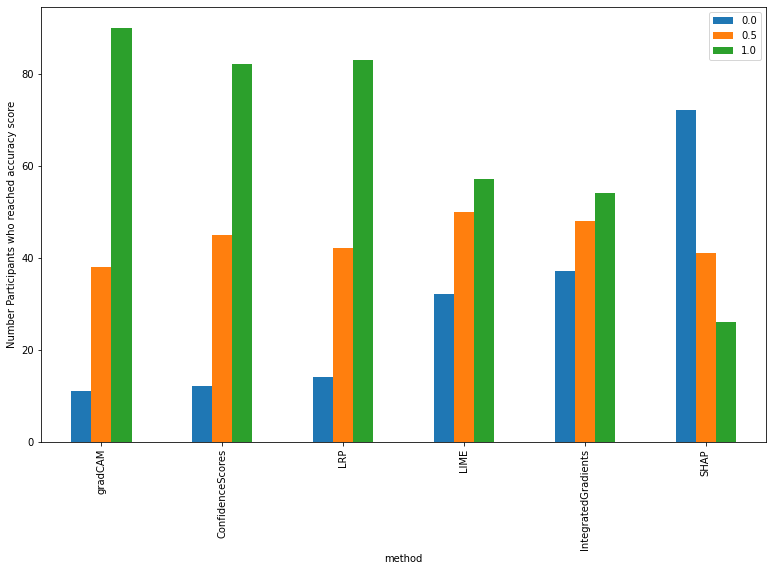

In [235]:
ax = df_sens_frequencies[df_sens_mean.index].transpose().plot.bar(figsize=(13, 8))
ax.set_ylabel("Number Participants who reached accuracy score")

### Significance & Effect Size: Sensitivity comparisons to random baseline

#### 1-sample t-test

In [292]:
# test with flexibile alternative
ser_sens_1_sample_t_values = df_sens_pivot.apply(lambda metric_method: perform_t_test_with_flexible_alternative(metric_method, mean_h_0, ALPHA))

ConfidenceScores:  sample_mean=0.7517985611510791
H0: sample_mean <= 0.5
p-value: 0.0
Reject H0! (alpha=0.05)

IntegratedGradients:  sample_mean=0.5611510791366906
H0: sample_mean <= 0.5
p-value: 0.037
Reject H0! (alpha=0.05)

LIME:  sample_mean=0.5899280575539568
H0: sample_mean <= 0.5
p-value: 0.004
Reject H0! (alpha=0.05)

LRP:  sample_mean=0.7482014388489209
H0: sample_mean <= 0.5
p-value: 0.0
Reject H0! (alpha=0.05)

SHAP:  sample_mean=0.3345323741007194
H0: sample_mean >= 0.5
p-value: 0.0
Reject H0! (alpha=0.05)

gradCAM:  sample_mean=0.7841726618705036
H0: sample_mean <= 0.5
p-value: 0.0
Reject H0! (alpha=0.05)



In [313]:
# overall test
df_sens_overall = df_sens_pivot.mean(axis=1)
t_sens_overall = perform_t_test(df_sens_overall, mean_h_0, ALPHA, "greater")
effect_sens_overall = cohens_d(t_sens_overall, len(df_sens_overall))
effect_sens_overall

None
p-value: 0.0
Reject H0: accuracy_mean <= 0.5 



0.7202525778433363

In [314]:
df_sens_overall.mean()

0.6282973621103116

#### Effect size (Cohens d) 

In [293]:
N_sens = df_sens_pivot.shape[0]
df_sens_1_sample_effect = ser_sens_1_sample_t_values.map(lambda t_val: cohens_d(t_val, N_sens)).to_frame("cohens_d").sort_values(by="cohens_d", ascending=False)

In [295]:
df_sens_1_sample_effect.round(2)

,cohens_d
method,
gradCAM,0.89
ConfidenceScores,0.77
LRP,0.74
LIME,0.23
IntegratedGradients,0.15
SHAP,-0.43


### Significance & Effect Size: Sensitivity pairwise between in each other

#### Paired t-test

In [239]:
df_sens_paired_test_alternatives, df_sens_apaired_test_pvalues = get_pairwise_paired_t_test_alternatives_and_p_values(df_sens_pivot, df_sens_mean)


In [240]:
df_sens_paired_test_alternatives

method_j,gradCAM,ConfidenceScores,LRP,LIME,IntegratedGradients,SHAP
method_i,,,,,,
gradCAM,None,greater,greater,greater,greater,greater
ConfidenceScores,less,None,greater,greater,greater,greater
LRP,less,less,None,greater,greater,greater
LIME,less,less,less,None,greater,greater
IntegratedGradients,less,less,less,less,None,greater
SHAP,less,less,less,less,less,None


In [241]:
df_sens_apaired_test_pvalues

method_j,gradCAM,ConfidenceScores,LRP,LIME,IntegratedGradients,SHAP
method_i,,,,,,
gradCAM,NaN,0.186,0.162,0.000,0.000,0.0
ConfidenceScores,0.186,NaN,0.462,0.000,0.000,0.0
LRP,0.162,0.462,NaN,0.000,0.000,0.0
LIME,0.000,0.000,0.000,NaN,0.276,0.0
IntegratedGradients,0.000,0.000,0.000,0.276,NaN,0.0
SHAP,0.000,0.000,0.000,0.000,0.000,NaN


In [242]:
df_sens_apaired_test_pvalues < ALPHA

method_j,gradCAM,ConfidenceScores,LRP,LIME,IntegratedGradients,SHAP
method_i,,,,,,
gradCAM,False,False,False,True,True,True
ConfidenceScores,False,False,False,True,True,True
LRP,False,False,False,True,True,True
LIME,True,True,True,False,False,True
IntegratedGradients,True,True,True,False,False,True
SHAP,True,True,True,True,True,False


In [243]:
# Test Results for Sensitivity (rowise and only the upper diagonal because symmetric)

# gradCAM's sensitivity isnt't significantly greater than CS's and LRP's but bigger than of LIME, IG and SHAP
# CS's sensitivity isnt't significantly greater than LRP's but bigger than of LIME, IG and SHAP
# LRP's sensitivity is significantly greater than LIME's, IG's and SHAP's.
# LIME's sensitivity isn't significantly greater than IG's but bigger than SHAP's
# IG's sensitivity is significantly greater than SHAPS's.
# (SHAPS sensitivity is significantly smaller than all others) --> this is an implication of the above mentioned

#### Effect size in compare (Cohens d)

## 3. Specificity

In [244]:
df_spec = specificity_per_groupby(df_merged, group_by=["method", "case"])
df_spec_pivot = df_spec.reset_index().pivot(index="case", columns="method", values="specificity")
df_spec_frequencies = df_spec_pivot.apply(lambda x: x.value_counts())
df_spec_conv = get_metric_convergence(df_spec)

### Specificity means

In [245]:
df_spec_mean = df_spec_pivot.mean().to_frame("mean").sort_values(by="mean", ascending=False)
df_spec_mean.round(2)

,mean
method,
SHAP,0.78
ConfidenceScores,0.64
IntegratedGradients,0.50
LIME,0.50
gradCAM,0.42
LRP,0.42


In [246]:
# overall
df_spec_mean.mean().to_frame("accuracy").mean()

accuracy    0.544365
dtype: float64

### Specificity boxplots

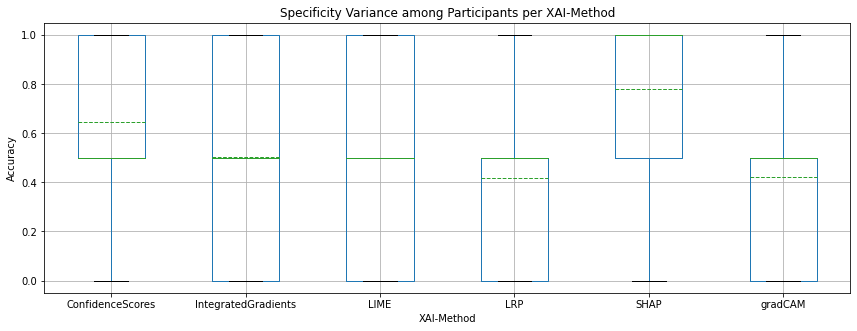

In [247]:
plot_metric_boxplot(df_spec.reset_index(), ["method"], "specificity", title="Specificity Variance among Participants per XAI-Method")

### Specificity convergence

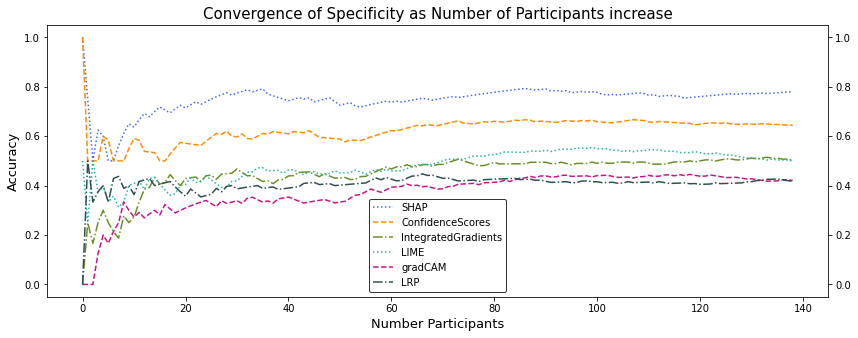

In [248]:
plot_metric_convergence(df_spec_conv, metric_name="Specificity")

### Specificity values frequencies (all possible discrete according to question resolution)

Text(0, 0.5, 'Number Participants who reached accuracy score')

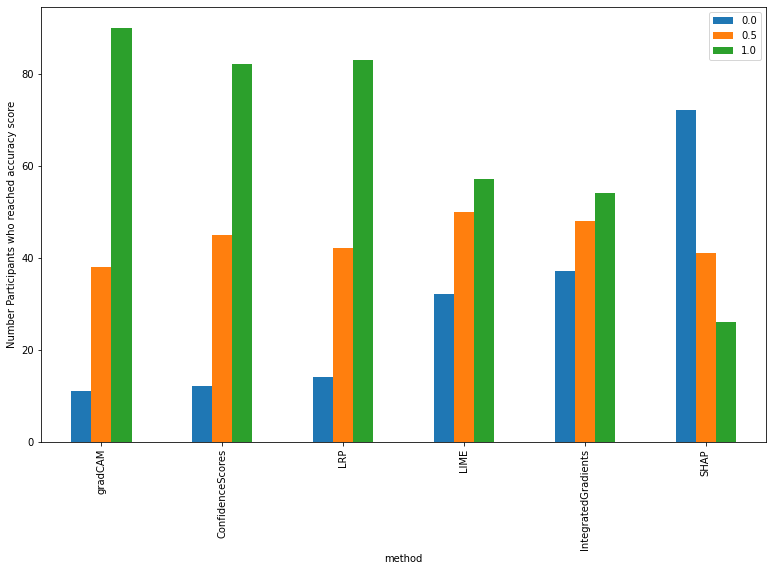

In [249]:
ax = df_sens_frequencies[df_sens_mean.index].transpose().plot.bar(figsize=(13, 8))
ax.set_ylabel("Number Participants who reached accuracy score")

### Significance & Effect Size: Specificity comparisons to random baseline

#### 1-sample t-test

In [298]:
# test with flexibile alternative
ser_spec_1_sample_t_values = df_spec_pivot.apply(lambda metric_method: perform_t_test_with_flexible_alternative(metric_method, mean_h_0, ALPHA))

ConfidenceScores:  sample_mean=0.6438848920863309
H0: sample_mean <= 0.5
p-value: 0.0
Reject H0! (alpha=0.05)

IntegratedGradients:  sample_mean=0.5035971223021583
H0: sample_mean <= 0.5
p-value: 0.458
CAN'T reject H0: (alpha=0.05)

LIME:  sample_mean=0.5
H0: sample_mean equal 0.5
p-value: 1.0
CAN'T reject H0: (alpha=0.05)

LRP:  sample_mean=0.4172661870503597
H0: sample_mean >= 0.5
p-value: 0.002
Reject H0! (alpha=0.05)

SHAP:  sample_mean=0.7805755395683454
H0: sample_mean <= 0.5
p-value: 0.0
Reject H0! (alpha=0.05)

gradCAM:  sample_mean=0.420863309352518
H0: sample_mean >= 0.5
p-value: 0.007
Reject H0! (alpha=0.05)



In [315]:
# overall test
df_spec_overall = df_spec_pivot.mean(axis=1)
t_spec_overall = perform_t_test(df_spec_overall, mean_h_0, ALPHA, "greater")
effect_spec_overall = cohens_d(t_spec_overall, len(df_spec_overall))
effect_spec_overall

None
p-value: 0.002
Reject H0: accuracy_mean <= 0.5 



0.2560432122239982

In [316]:
df_spec_overall.mean()

0.5443645083932853

#### Effect size (Cohens d) 

In [299]:
N_spec = df_spec_pivot.shape[0]
df_spec_1_sample_effect = ser_spec_1_sample_t_values.map(lambda t_val: cohens_d(t_val, N_sens)).to_frame("cohens_d").sort_values(by="cohens_d", ascending=False)

In [300]:
df_spec_1_sample_effect.round(2)

,cohens_d
method,
SHAP,0.85
ConfidenceScores,0.44
IntegratedGradients,0.01
LIME,0.00
gradCAM,-0.21
LRP,-0.25


### Significance & Effect Size: Specificity pairwise between in each other

#### Paired t-test

In [253]:
df_spec_paired_test_alternatives, df_spec_apaired_test_pvalues = get_pairwise_paired_t_test_alternatives_and_p_values(df_spec_pivot, df_spec_mean)


In [254]:
df_spec_paired_test_alternatives

method_j,SHAP,ConfidenceScores,IntegratedGradients,LIME,gradCAM,LRP
method_i,,,,,,
SHAP,None,greater,greater,greater,greater,greater
ConfidenceScores,less,None,greater,greater,greater,greater
IntegratedGradients,less,less,None,greater,greater,greater
LIME,less,less,less,None,greater,greater
gradCAM,less,less,less,less,None,greater
LRP,less,less,less,less,less,None


In [255]:
df_spec_apaired_test_pvalues

method_j,SHAP,ConfidenceScores,IntegratedGradients,LIME,gradCAM,LRP
method_i,,,,,,
SHAP,NaN,0.0,0.000,0.000,0.000,0.000
ConfidenceScores,0.0,NaN,0.000,0.000,0.000,0.000
IntegratedGradients,0.0,0.0,NaN,0.470,0.026,0.025
LIME,0.0,0.0,0.470,NaN,0.028,0.021
gradCAM,0.0,0.0,0.026,0.028,NaN,0.466
LRP,0.0,0.0,0.025,0.021,0.466,NaN


In [256]:
df_spec_apaired_test_pvalues < ALPHA

method_j,SHAP,ConfidenceScores,IntegratedGradients,LIME,gradCAM,LRP
method_i,,,,,,
SHAP,False,True,True,True,True,True
ConfidenceScores,True,False,True,True,True,True
IntegratedGradients,True,True,False,False,True,True
LIME,True,True,False,False,True,True
gradCAM,True,True,True,True,False,False
LRP,True,True,True,True,False,False


In [258]:
df_spec_mean

,mean
method,
SHAP,0.780576
ConfidenceScores,0.643885
IntegratedGradients,0.503597
LIME,0.500000
gradCAM,0.420863
LRP,0.417266


#### Effect size in compare (Cohens d)

## 4. Sensitivity vs. Specificity per method

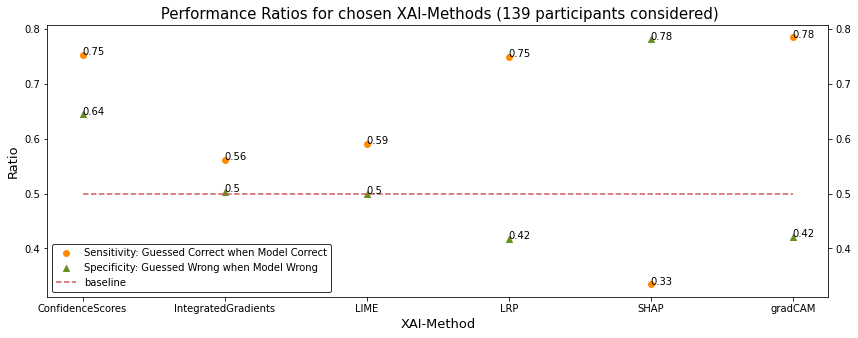

In [259]:
plot_sensitivity_specificity(df_sens_mean, df_spec_mean, title_addition="")

#### Sensitvity/ Specificity only on fixed images

In [260]:
fixed_img_idxs = df_quest_meta["img_idx"].value_counts()[df_quest_meta["img_idx"].value_counts() == 12].index
df_quest_meta_fixed = df_quest_meta[df_quest_meta["img_idx"].isin(fixed_img_idxs)]

## 5. Analysis: Participants characteristics on accuracy

### Accuracy for different education levels

In [261]:
df_accuracy_edu_method = accuracy_per_groupby(df_merged, group_by=["Education", "method"])

/var/folders/w5/m5wrj2m93qscdptzjbh3khlr0000gn/T/ipykernel_91916/3268111246.py:9: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  ser_acc_mean = df_double_index.mean(level=0)[df_double_index.columns[0]]


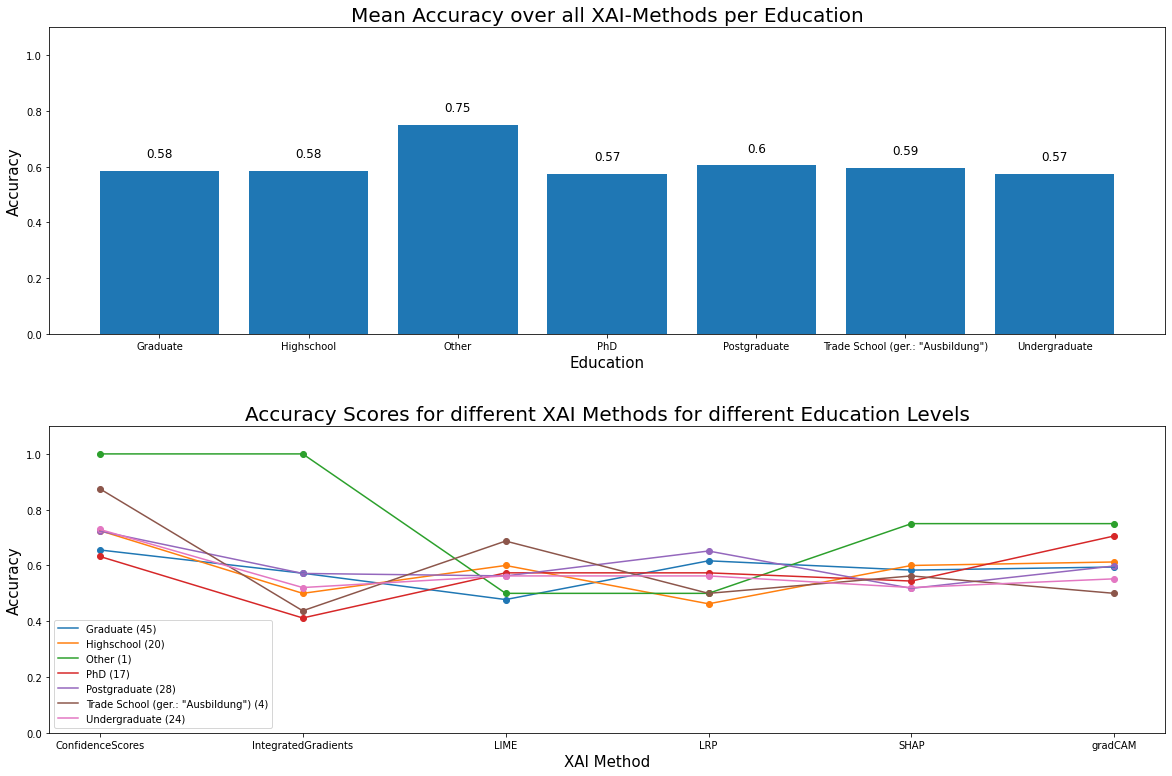

In [262]:
plot_2_indexes_1_plot(df_accuracy_edu_method, "XAI Method", "Accuracy", "Accuracy Scores for different XAI Methods for different Education Levels")

/var/folders/w5/m5wrj2m93qscdptzjbh3khlr0000gn/T/ipykernel_91916/3053124865.py:8: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  ser_acc_mean = df_double_index.mean(level=0)[df_double_index.columns[0]]


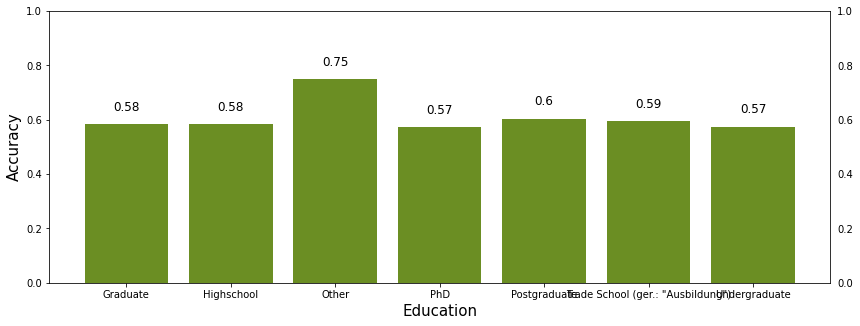

In [263]:
bar_plot(df_accuracy_edu_method,"education")

### Accuracy for different ML-Experience

In [264]:
df_accuracy_mlex_method = accuracy_per_groupby(df_merged, group_by=["ML Experience", "method"])

/var/folders/w5/m5wrj2m93qscdptzjbh3khlr0000gn/T/ipykernel_91916/3268111246.py:9: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  ser_acc_mean = df_double_index.mean(level=0)[df_double_index.columns[0]]


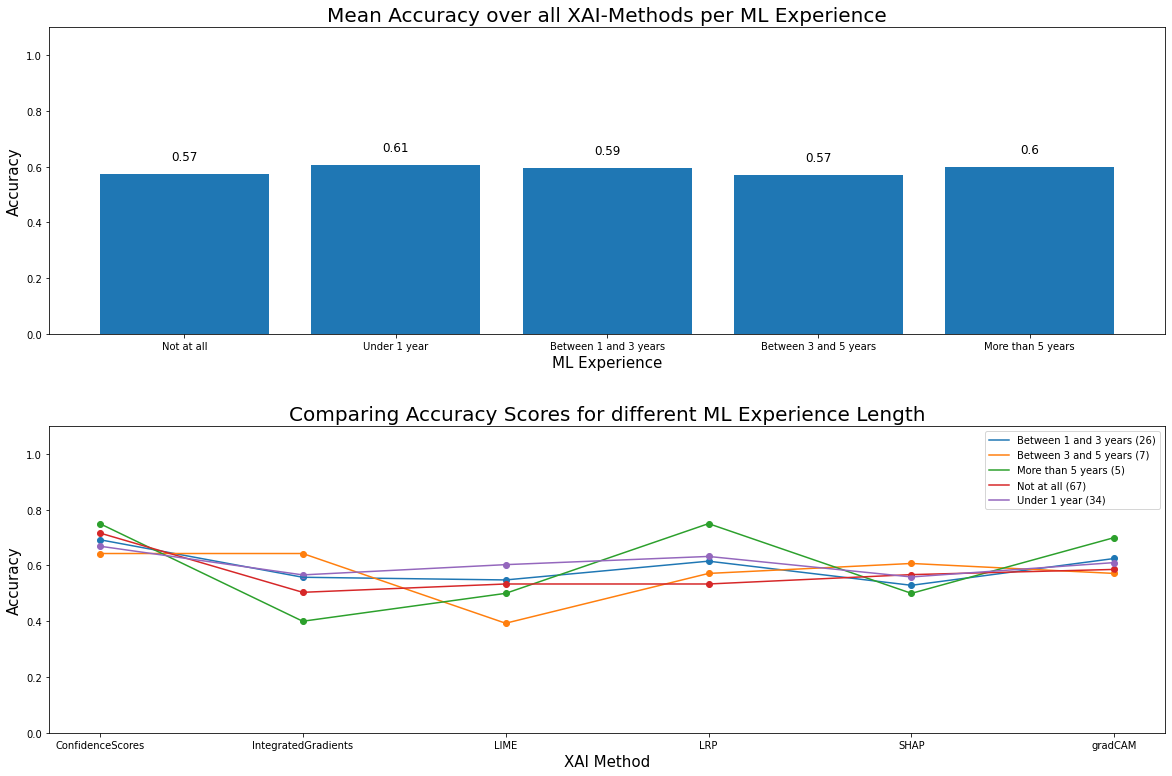

In [265]:
plot_2_indexes_1_plot(df_accuracy_mlex_method, "XAI Method", "Accuracy", "Comparing Accuracy Scores for different ML Experience Length", mean_idx_order=["Not at all", "Under 1 year", "Between 1 and 3 years", "Between 3 and 5 years", "More than 5 years"])

/var/folders/w5/m5wrj2m93qscdptzjbh3khlr0000gn/T/ipykernel_91916/3053124865.py:8: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  ser_acc_mean = df_double_index.mean(level=0)[df_double_index.columns[0]]


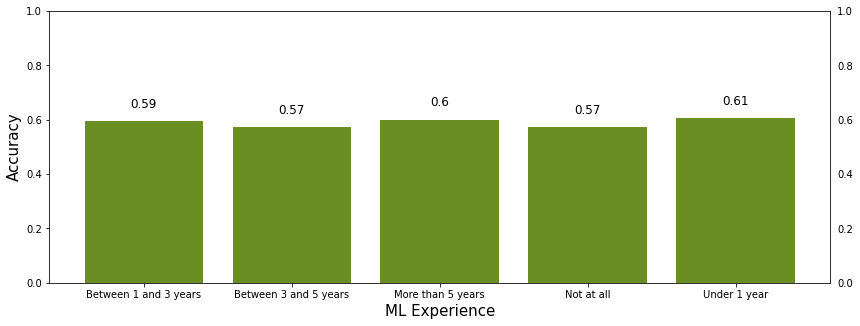

In [266]:
bar_plot(df_accuracy_mlex_method,"ml_exp")

### Accuracy for different perceived ML-Experience Usefulness

In [267]:
df_accuracy_xaiusef_method = accuracy_per_groupby(df_merged, group_by=["ML Experience Usefulness", "method"])

/Users/julianvonklitzing/miniforge3/envs/xai_env/lib/python3.8/site-packages/pandas/core/indexes/multi.py:3635: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress this warning.
  result = lib.fast_unique_multiple([self._values, rvals], sort=sort)


/var/folders/w5/m5wrj2m93qscdptzjbh3khlr0000gn/T/ipykernel_91916/3268111246.py:9: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  ser_acc_mean = df_double_index.mean(level=0)[df_double_index.columns[0]]


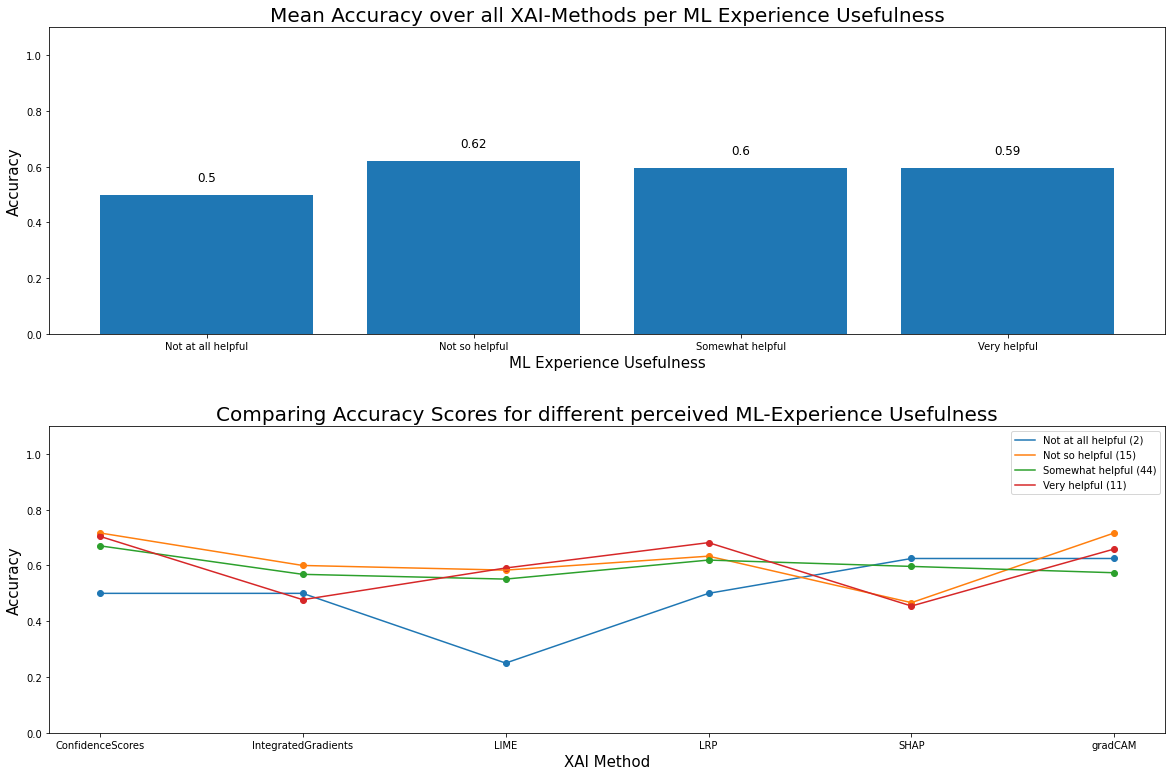

In [268]:
plot_2_indexes_1_plot(df_accuracy_xaiusef_method, "XAI Method", "Accuracy", "Comparing Accuracy Scores for different perceived ML-Experience Usefulness")

/var/folders/w5/m5wrj2m93qscdptzjbh3khlr0000gn/T/ipykernel_91916/3053124865.py:8: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  ser_acc_mean = df_double_index.mean(level=0)[df_double_index.columns[0]]


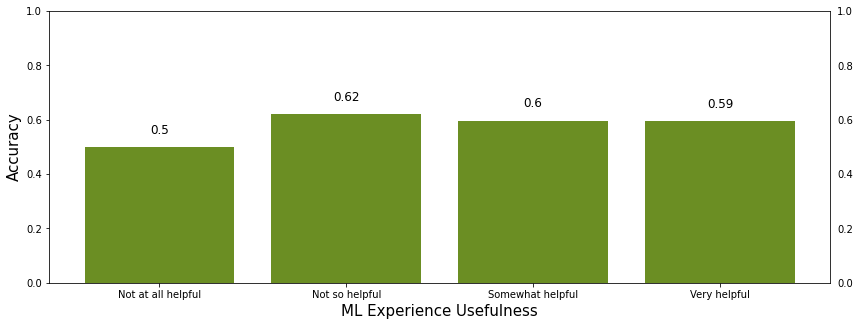

In [269]:
bar_plot(df_accuracy_xaiusef_method,"ml_exp_self")

### Accuracy for visual impairment

In [270]:
df_accuracy_visimp_method = accuracy_per_groupby(df_merged, group_by=["Visual Impairment Affect", "method"], drop_na=True)

/var/folders/w5/m5wrj2m93qscdptzjbh3khlr0000gn/T/ipykernel_91916/3268111246.py:9: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  ser_acc_mean = df_double_index.mean(level=0)[df_double_index.columns[0]]


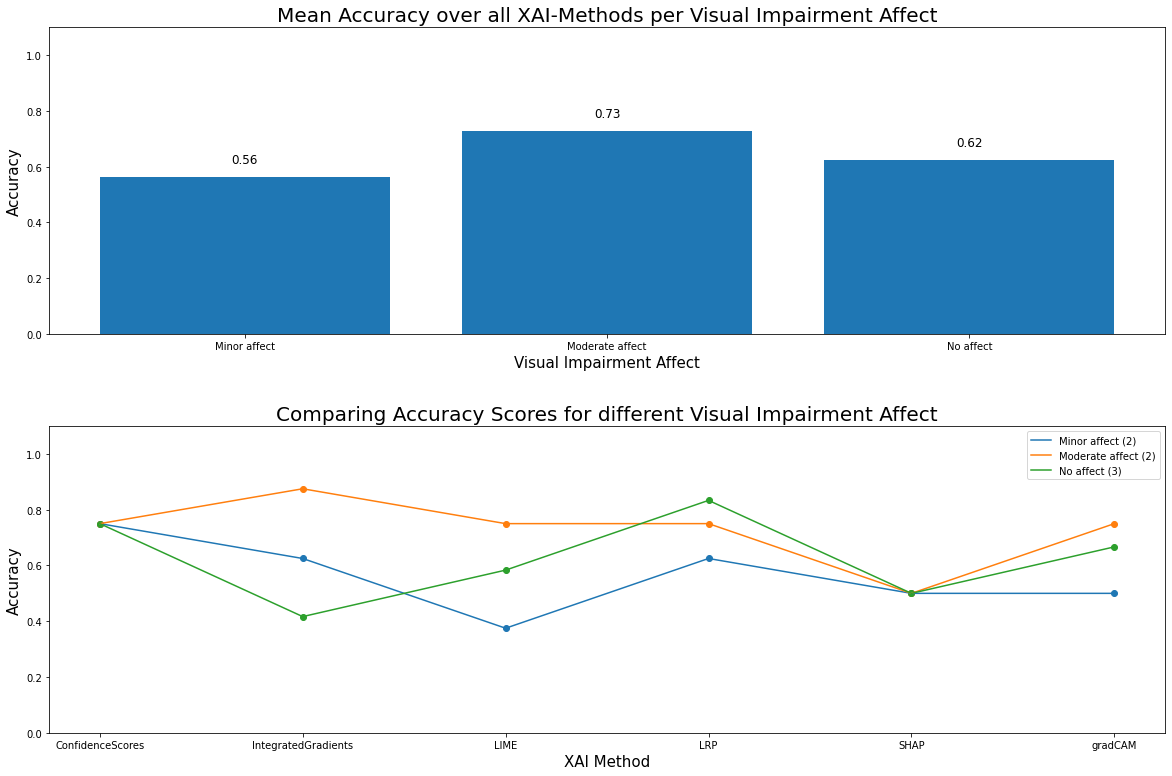

In [271]:
plot_2_indexes_1_plot(df_accuracy_visimp_method, "XAI Method", "Accuracy", "Comparing Accuracy Scores for different Visual Impairment Affect", drop_duplicates=True)

/var/folders/w5/m5wrj2m93qscdptzjbh3khlr0000gn/T/ipykernel_91916/3053124865.py:8: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  ser_acc_mean = df_double_index.mean(level=0)[df_double_index.columns[0]]


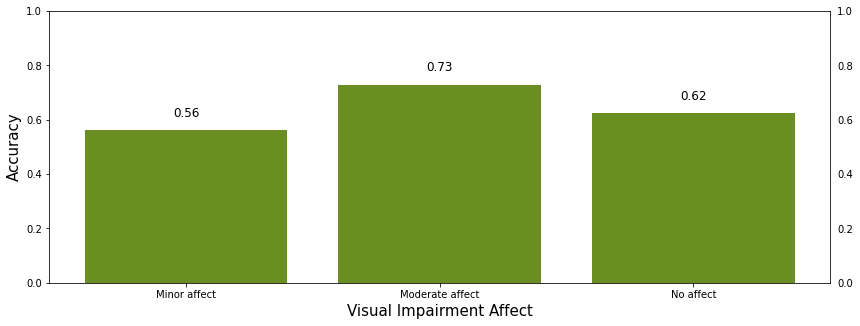

In [272]:
bar_plot(df_accuracy_visimp_method,"visual")

### Accuracy for colorblindness yes/no

In [273]:
df_accuracy_colorb_method = accuracy_per_groupby(df_merged, group_by=["Color Blindness", "method"])

/var/folders/w5/m5wrj2m93qscdptzjbh3khlr0000gn/T/ipykernel_91916/3268111246.py:9: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  ser_acc_mean = df_double_index.mean(level=0)[df_double_index.columns[0]]


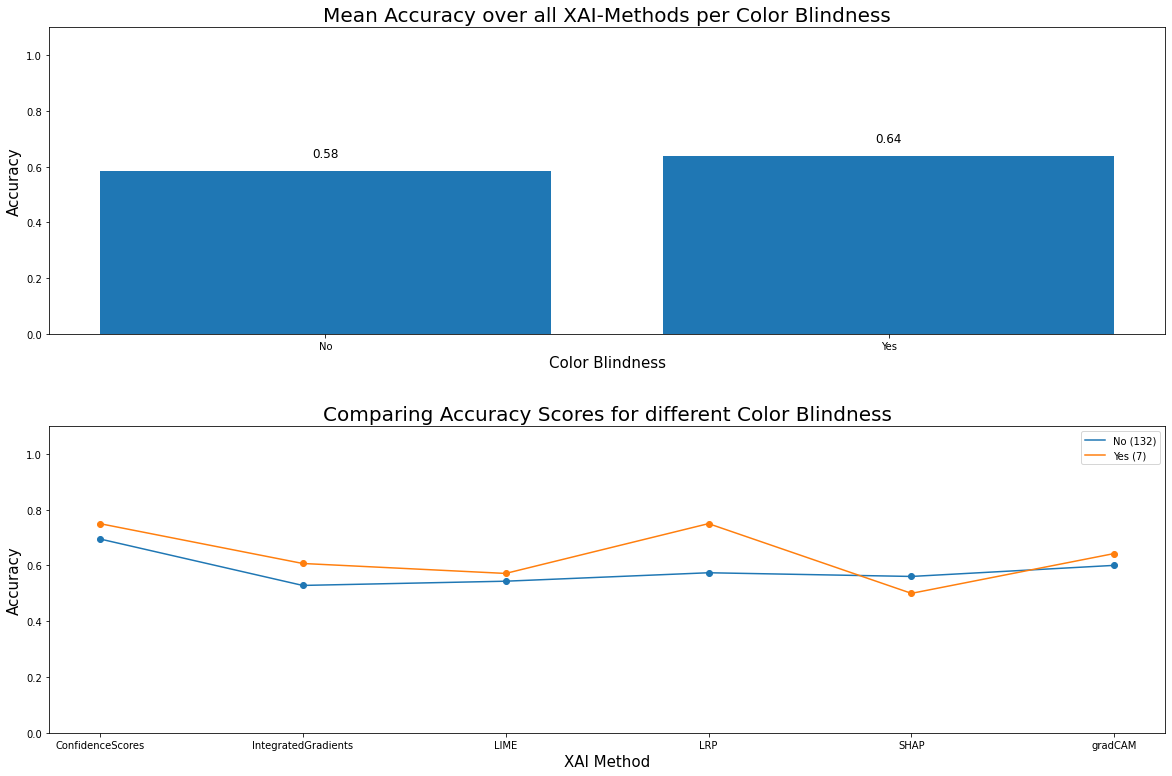

In [274]:
plot_2_indexes_1_plot(df_accuracy_colorb_method, "XAI Method", "Accuracy", "Comparing Accuracy Scores for different Color Blindness", drop_duplicates=True)

## 6. Accuracy for different models

In [275]:
df_accuracy_model_method = accuracy_per_groupby(df_merged, group_by=["model", "method"])

/var/folders/w5/m5wrj2m93qscdptzjbh3khlr0000gn/T/ipykernel_91916/3268111246.py:9: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  ser_acc_mean = df_double_index.mean(level=0)[df_double_index.columns[0]]


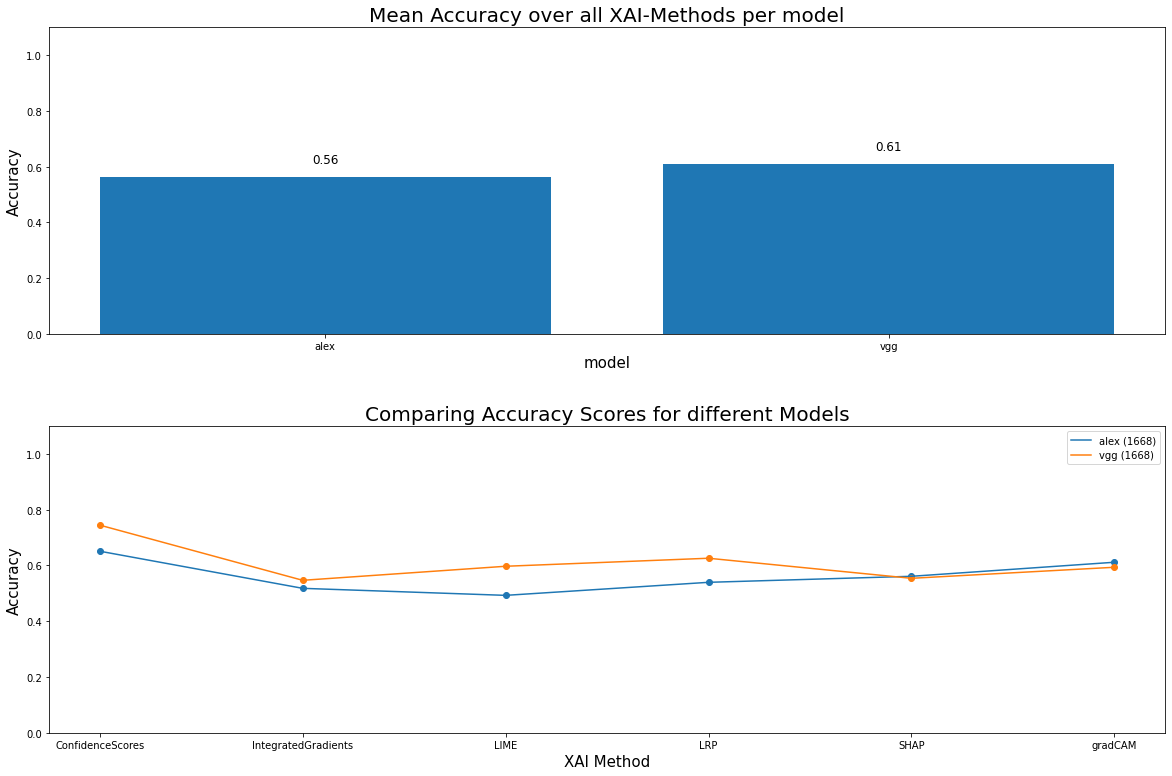

In [276]:
plot_2_indexes_1_plot(df_accuracy_model_method, "XAI Method", "Accuracy", "Comparing Accuracy Scores for different Models", drop_duplicates=False)

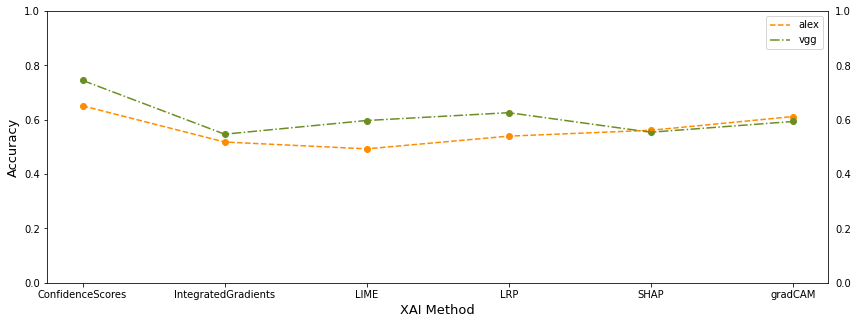

In [277]:
line_plot(df_accuracy_model_method, "XAI Method", "Accuracy","models")

## 7. Metrics per questionnaire form (detect outlier questionnaires)

In [278]:
df_accuracy_qustnr_method = accuracy_per_groupby(df_merged, group_by=["QUESTNNR", "method"])

/var/folders/w5/m5wrj2m93qscdptzjbh3khlr0000gn/T/ipykernel_91916/3268111246.py:9: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  ser_acc_mean = df_double_index.mean(level=0)[df_double_index.columns[0]]


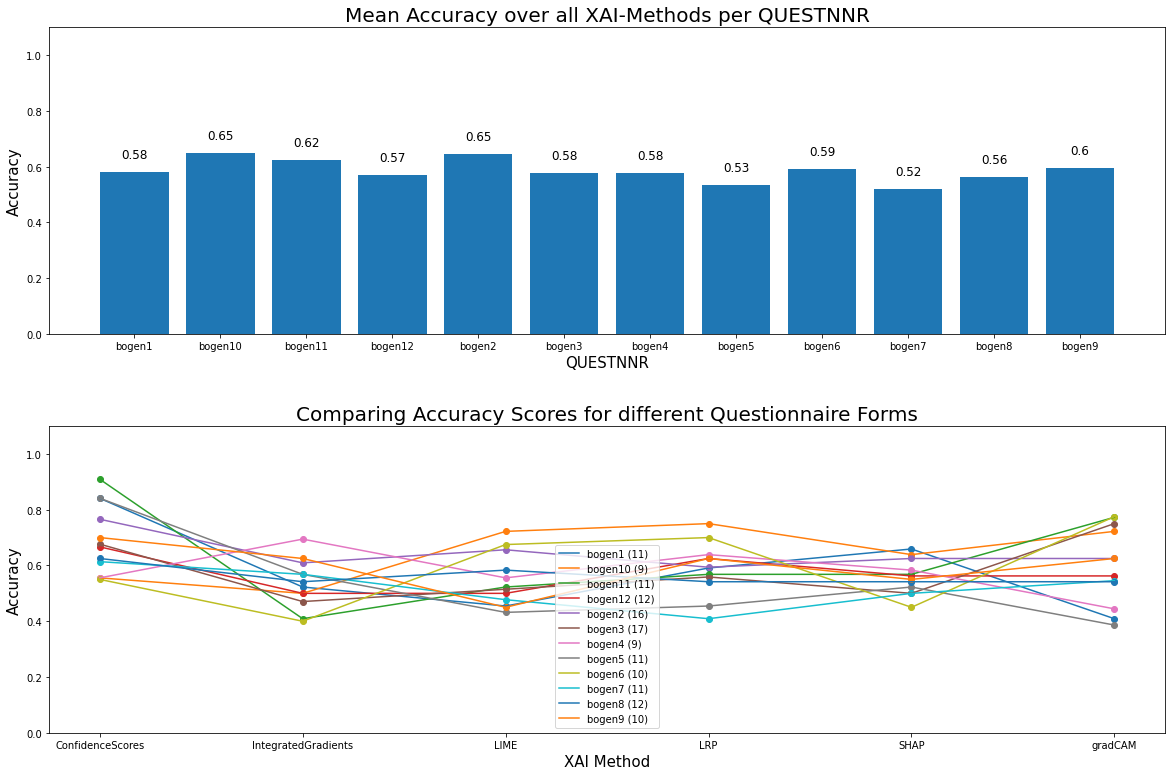

In [279]:
plot_2_indexes_1_plot(df_accuracy_qustnr_method, "XAI Method", "Accuracy", "Comparing Accuracy Scores for different Questionnaire Forms")